<a href="https://colab.research.google.com/github/businsweetie/deep_learning/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт бибилиотек и функции

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Dropout

from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

tf.random.set_seed(43)

In [3]:
EPOCHS = 50
BATCH_SIZE = 32

In [4]:
def plot_training_curves(history):
  loss_values = history.history['loss'] # ошибка на тренировочном наборе
  val_loss_values = history.history['val_loss'] # ошибка на валидационном наборе
  mae_values = history.history['mae']  # mae на тренировочном наборе
  val_mae_values = history.history['val_mae'] # mae на валидационном наборе

  epochs_x = range(1, len(loss_values) + 1) # количество эпох обучения

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # график значения функции потерь на каждой эпохе
  ax1.plot(epochs_x, loss_values, 'b', label='Обучение')
  ax1.plot(epochs_x, val_loss_values, 'r', label='Валидация')
  ax1.set_title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  ax1.set_xlabel('Эпохи', fontsize=12)
  ax1.set_ylabel('Значение ошибки', fontsize=12)
  ax1.grid()
  ax1.legend()

  # график значения точности на каждой эпохе
  ax2.plot(epochs_x, mae_values, 'b', label='Обучение')
  ax2.plot(epochs_x, val_mae_values, 'r', label='Валидация')
  ax2.set_title('MAE при обучении и валидации', fontsize=14, fontweight="bold")
  ax2.set_xlabel('Эпохи', fontsize=12)
  ax2.set_ylabel('Значение точности', fontsize=12)
  ax2.grid()
  ax2.legend()

  return

def generate_preformance_scores(y_true, y_pred):

  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print(f'mse:\t{mse:.4f}')
  print(f'mae:\t{mae:.4f}')
  print(f'r2:\t{r2:.4f}')

  return

def temperature_plot(y_test, y_pred):
  fig, ax = plt.subplots(figsize=(15, 5))

  ax.plot(y_test, c = "g", alpha = 1, label="Тест")
  ax.plot(y_pred, c = "darkblue", alpha = 0.5, label="Предсказание")
  ax.set_title('Сравнение актуальных и предсказанных данных', fontsize=14, fontweight="bold")
  ax.set_xlim(0, len(y_test))
  ax.grid()
  ax.legend()

  return

# Чтение данных

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/datasets/kaliningrad_weather.csv', sep=";", encoding="windows-1251", encoding_errors='replace', index_col="LocalTime")
df.head()

,T,Po,P,Pa,U,DD
LocalTime,,,,,,
19.10.2020 11:00,8.0,761.2,762.5,NaN,83.0,Ветер
19.10.2020 08:00,5.3,760.0,761.3,NaN,90.0,Ветер
19.10.2020 05:00,3.1,759.2,760.6,NaN,94.0,Ветер
19.10.2020 02:00,2.9,758.2,759.6,NaN,90.0,Ветер
18.10.2020 23:00,3.0,757.2,758.5,NaN,91.0,Ветер


In [6]:
df.shape

(26269, 6)

# Обработка и исследование данных

In [7]:
df = df.drop(["Pa", "DD"], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26269 entries, 19.10.2020 11:00 to 15.10.2011 02:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       26253 non-null  float64
 1   Po      26237 non-null  float64
 2   P       26221 non-null  float64
 3   U       26233 non-null  float64
dtypes: float64(4)
memory usage: 1.0+ MB


In [9]:
df.describe()

,T,Po,P,U
count,26253.000000,26237.000000,26221.000000,26233.000000
mean,8.948920,759.497168,761.470325,79.552281
std,8.362079,7.150198,7.175658,16.083324
min,-24.300000,727.800000,729.700000,19.000000
25%,3.000000,755.200000,757.200000,70.000000
50%,8.400000,759.700000,761.600000,84.000000
75%,15.200000,764.000000,766.000000,93.000000
max,34.800000,783.400000,785.600000,100.000000


In [10]:
df.isna().sum()

T     16
Po    32
P     48
U     36
dtype: int64

In [11]:
df = df.dropna()
df.isna().sum()

T     0
Po    0
P     0
U     0
dtype: int64

In [12]:
df.shape

(26186, 4)

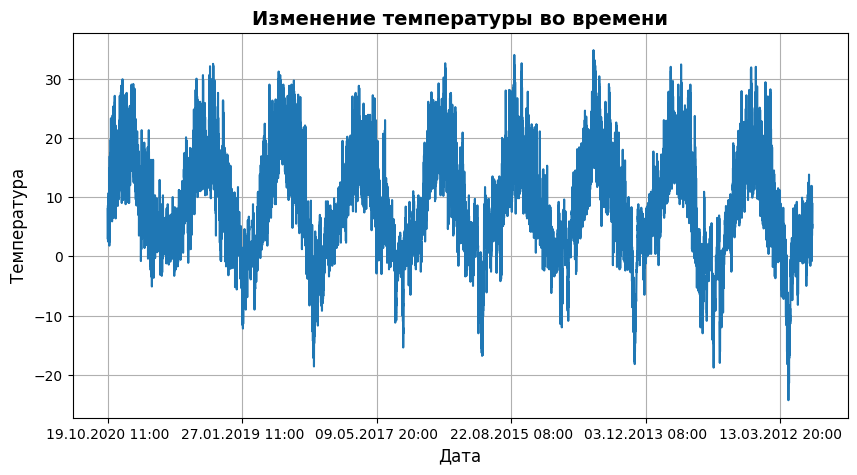

In [13]:
plt.figure(figsize=(10, 5))
df["T"].plot()
plt.title("Изменение температуры во времени", fontsize=14, fontweight="bold")
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Температура", fontsize=12)
plt.grid()

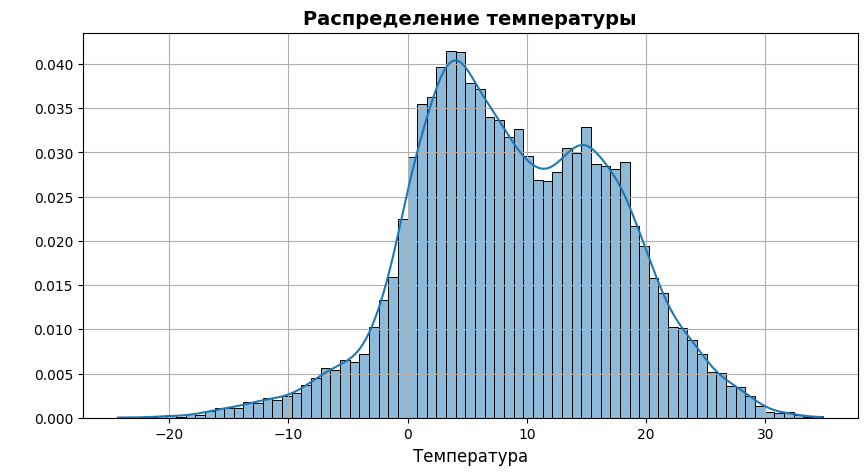

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(df['T'], kde=True, stat="probability")
plt.title("Распределение температуры", fontsize=14, fontweight="bold")
plt.xlabel("Температура", fontsize=12)
plt.ylabel(" ", fontsize=12)
plt.grid()

# Масштабирование данных

In [15]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [16]:
df_norm = normalize(df.values)
df_norm = pd.DataFrame(df_norm)
df_norm.head()

,0,1,2,3
0,-0.114276,0.237966,0.143873,0.215085
1,-0.437076,0.070110,-0.023328,0.650265
2,-0.700097,-0.041794,-0.120862,0.898939
3,-0.724008,-0.181674,-0.260196,0.650265
4,-0.712053,-0.321555,-0.413463,0.712433


# Деление на выборки

In [17]:
def load_data(data, look_back, test_set_ratio):
    data_raw = data.to_numpy()
    data = []

    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(test_set_ratio * data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size, :-1, :]
    y_train = np.squeeze(data[:train_set_size, -1, 0])

    x_test = data[train_set_size:, :-1]
    y_test = np.squeeze(data[train_set_size:, -1, 0])

    return [x_train, y_train, x_test, y_test]

In [18]:
look_back = 20

X_train, y_train, X_test, y_test = load_data(df_norm, look_back, test_set_ratio=0.1)

print('X_train.shape =', X_train.shape)
print('y_train.shape =', y_train.shape)
print('X_test.shape =', X_test.shape)
print('y_test.shape =', y_test.shape)

X_train.shape = (23549, 19, 4)
y_train.shape = (23549,)
X_test.shape = (2617, 19, 4)
y_test.shape = (2617,)


In [19]:
temp_mean = df["T"].mean(axis=0)
temp_std = df["T"].std(axis=0)

In [20]:
y_test = y_test * temp_std + temp_mean

# Модель 1

In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

callbacks_list = [early_stop]

## Модель 1.1

In [76]:
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(16, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 19, 8)             40        
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                400       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 457 (1.79 KB)
Trainable params: 457 (1.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
663/663 [==============================] - 24s 27ms/step - loss: 0.2759 - mae: 0.3434 - val_loss: 0.0827 - val_mae: 0.2140
Epoch 2/50
663/663 [==============================] - 19s 28ms/step - loss: 0.0670 - mae: 0.1953 - val_loss: 0.0596 - val_mae: 0.1794
Epoch 3/50
663/663 [==============================] - 19s 28ms/step - loss: 0.0550 - mae: 0.1755 - val_loss: 0.0502 - val_mae: 0.1645
Epoch 4/50
663/663 [==============================] - 20s 30ms/step - loss: 0.0485 - mae: 0.1643 - val_loss: 0.0444 - val_mae: 0.1551
Epoch 5/50
663/663 [==============================] - 17s 26ms/step - loss: 0.0432 - mae: 0.1547 - val_loss: 0.0401 - val_mae: 0.1450
Epoch 6/50
663/663 [==============================] - 18s 27ms/step - loss: 0.0400 - mae: 0.1488 - val_loss: 0.0395 - val_mae: 0.1435
Epoch 7/50
663/663 [==============================] - 17s 26ms/step - loss: 0.0378 - mae: 0.1450 - val_loss: 0.0358 - val_mae: 0.1376
Epoch 8/50
663/663 [==============================] - 18s 27ms

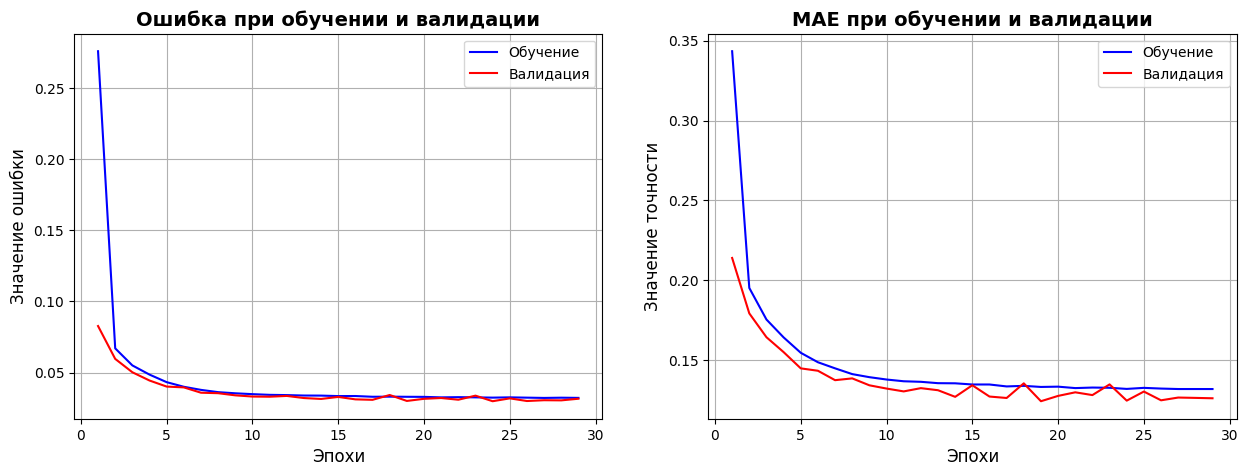

In [78]:
plot_training_curves(history)

mse:	2.3865
mae:	1.1353
r2:	0.9707


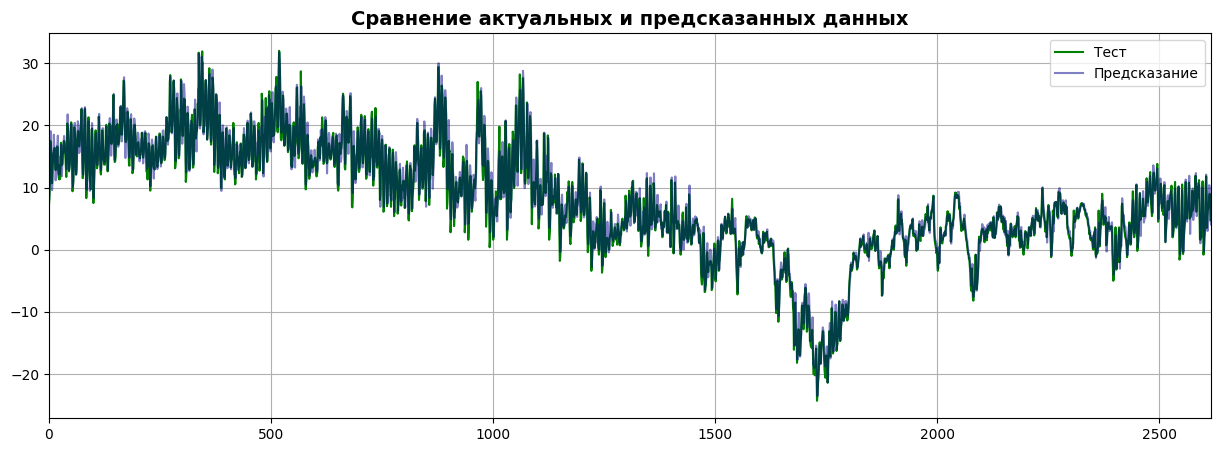

In [93]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 1.2

In [94]:
model = Sequential([
    Dense(4, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(8, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 19, 4)             20        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 104       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 133 (532.00 Byte)
Trainable params: 133 (532.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
663/663 [==============================] - 30s 42ms/step - loss: 0.3328 - mae: 0.4183 - val_loss: 0.1198 - val_mae: 0.2482
Epoch 2/50
663/663 [==============================] - 20s 30ms/step - loss: 0.1223 - mae: 0.2534 - val_loss: 0.0823 - val_mae: 0.1982
Epoch 3/50
663/663 [==============================] - 18s 27ms/step - loss: 0.0789 - mae: 0.2011 - val_loss: 0.0603 - val_mae: 0.1719
Epoch 4/50
663/663 [==============================] - 18s 26ms/step - loss: 0.0666 - mae: 0.1858 - val_loss: 0.0568 - val_mae: 0.1671
Epoch 5/50
663/663 [==============================] - 21s 32ms/step - loss: 0.0645 - mae: 0.1833 - val_loss: 0.0553 - val_mae: 0.1646
Epoch 6/50
663/663 [==============================] - 19s 28ms/step - loss: 0.0630 - mae: 0.1819 - val_loss: 0.0542 - val_mae: 0.1642
Epoch 7/50
663/663 [==============================] - 18s 27ms/step - loss: 0.0605 - mae: 0.1788 - val_loss: 0.0538 - val_mae: 0.1656
Epoch 8/50
663/663 [==============================] - 18s 27ms

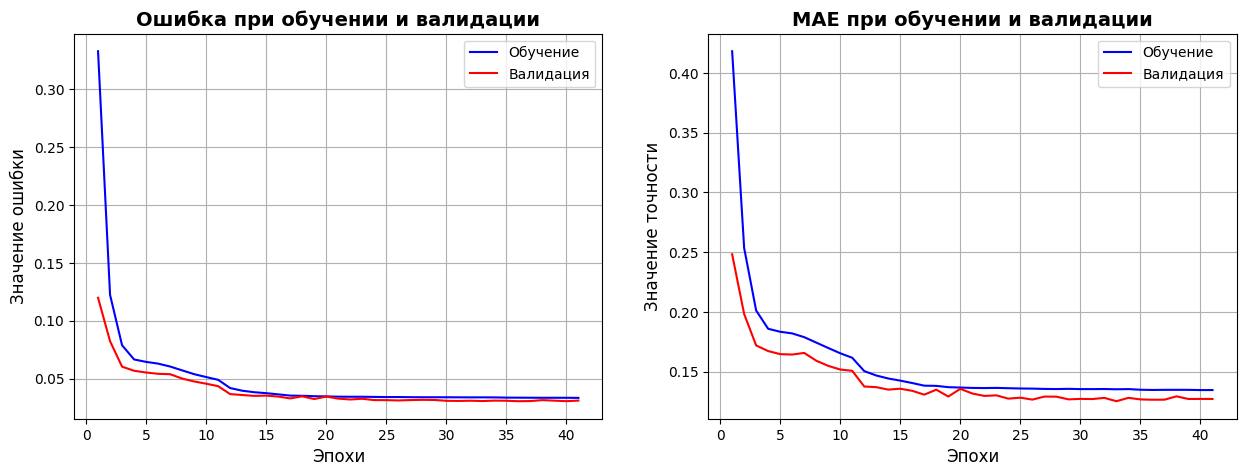

In [96]:
plot_training_curves(history)

82/82 [==============================] - 0s 4ms/step
mse:	2.3692
mae:	1.1452
r2:	0.9709


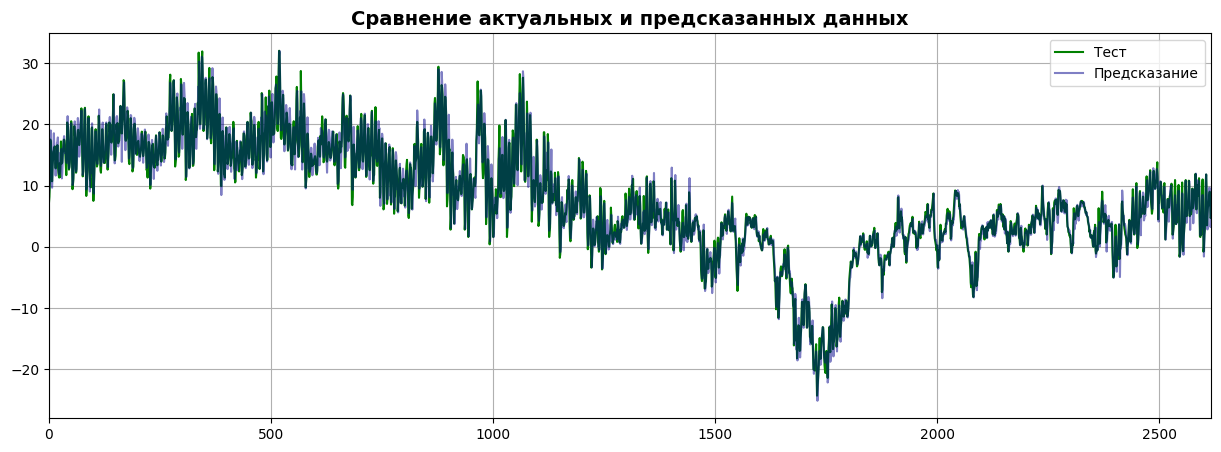

In [97]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 1.3

In [98]:
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(16, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='rmsprop', metrics='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 19, 8)             40        
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                400       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 457 (1.79 KB)
Trainable params: 457 (1.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [99]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
663/663 [==============================] - 27s 38ms/step - loss: 0.1380 - mae: 0.2644 - val_loss: 0.0662 - val_mae: 0.1851
Epoch 2/50
663/663 [==============================] - 17s 26ms/step - loss: 0.0571 - mae: 0.1772 - val_loss: 0.0477 - val_mae: 0.1601
Epoch 3/50
663/663 [==============================] - 17s 26ms/step - loss: 0.0468 - mae: 0.1600 - val_loss: 0.0756 - val_mae: 0.2142
Epoch 4/50
663/663 [==============================] - 18s 26ms/step - loss: 0.0434 - mae: 0.1536 - val_loss: 0.0448 - val_mae: 0.1575
Epoch 5/50
663/663 [==============================] - 18s 26ms/step - loss: 0.0413 - mae: 0.1498 - val_loss: 0.0394 - val_mae: 0.1451
Epoch 6/50
663/663 [==============================] - 17s 26ms/step - loss: 0.0397 - mae: 0.1468 - val_loss: 0.0451 - val_mae: 0.1566
Epoch 7/50
663/663 [==============================] - 17s 26ms/step - loss: 0.0384 - mae: 0.1444 - val_loss: 0.0385 - val_mae: 0.1436
Epoch 8/50
663/663 [==============================] - 18s 27ms

82/82 [==============================] - 0s 4ms/step
mse:	2.5524
mae:	1.1992
r2:	0.9686


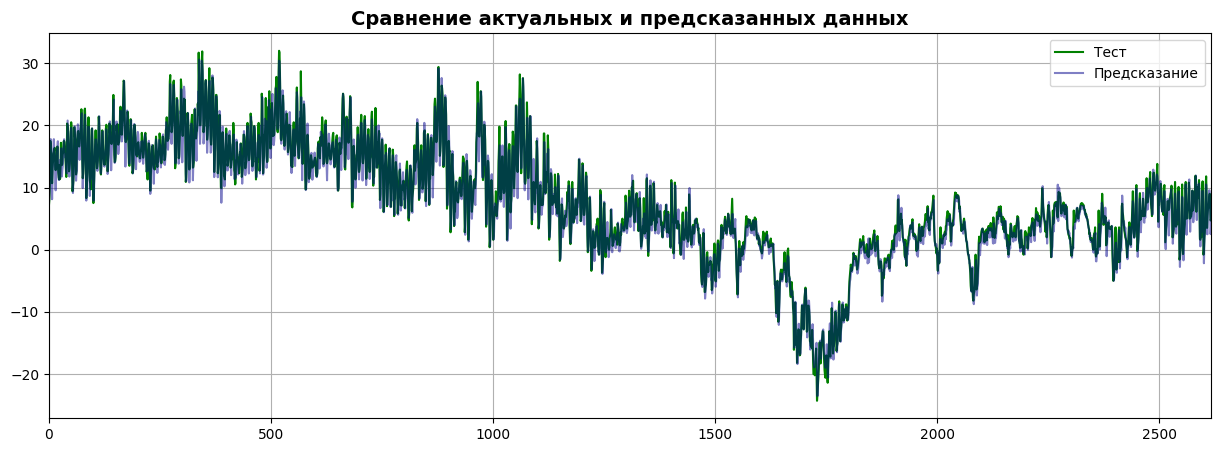

In [100]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

# Модель 2

## Модель 2.1

In [101]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 19, 32)            160       
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8513 (33.25 KB)
Trainable params: 8513 (33.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [102]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
663/663 [==============================] - 33s 45ms/step - loss: 0.0943 - mae: 0.2156 - val_loss: 0.0408 - val_mae: 0.1455
Epoch 2/50
663/663 [==============================] - 40s 60ms/step - loss: 0.0433 - mae: 0.1541 - val_loss: 0.0379 - val_mae: 0.1417
Epoch 3/50
663/663 [==============================] - 31s 48ms/step - loss: 0.0395 - mae: 0.1475 - val_loss: 0.0335 - val_mae: 0.1336
Epoch 4/50
663/663 [==============================] - 30s 46ms/step - loss: 0.0359 - mae: 0.1403 - val_loss: 0.0310 - val_mae: 0.1277
Epoch 5/50
663/663 [==============================] - 31s 46ms/step - loss: 0.0341 - mae: 0.1366 - val_loss: 0.0305 - val_mae: 0.1248
Epoch 6/50
663/663 [==============================] - 28s 42ms/step - loss: 0.0329 - mae: 0.1345 - val_loss: 0.0320 - val_mae: 0.1303
Epoch 7/50
663/663 [==============================] - 31s 46ms/step - loss: 0.0322 - mae: 0.1324 - val_loss: 0.0303 - val_mae: 0.1283
Epoch 8/50
663/663 [==============================] - 34s 52ms

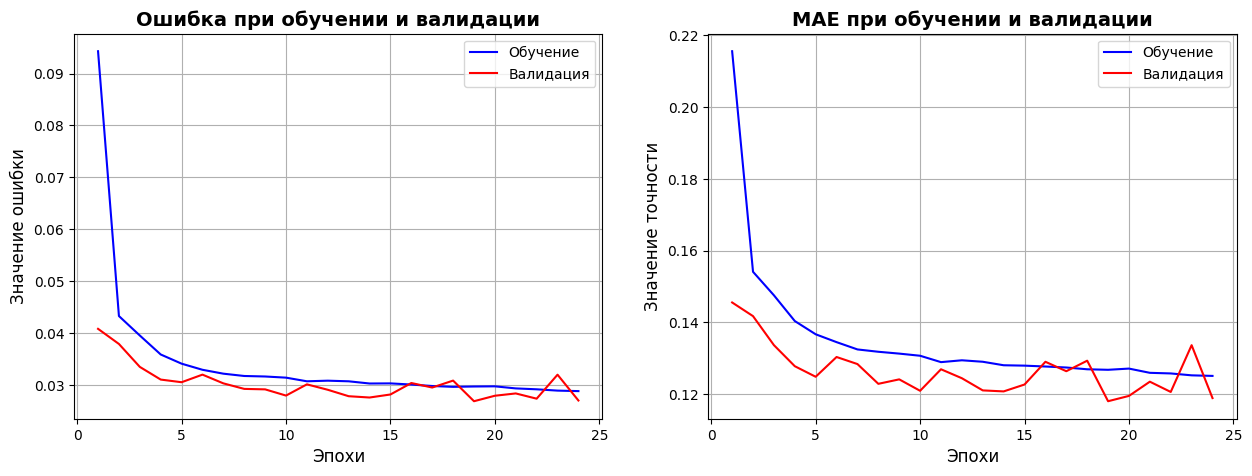

In [103]:
plot_training_curves(history)

82/82 [==============================] - 1s 5ms/step
mse:	2.2442
mae:	1.1001
r2:	0.9724


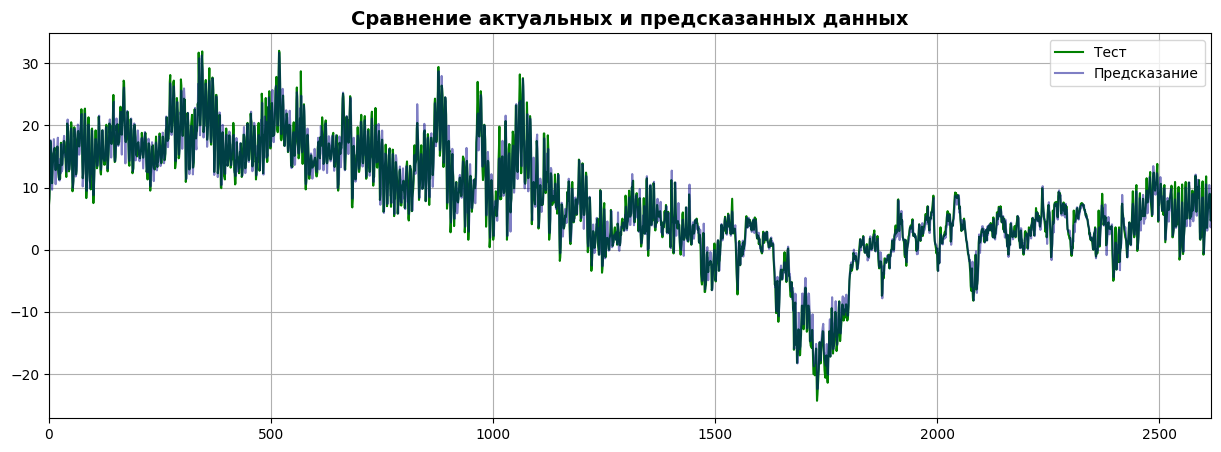

In [104]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 2.2

In [109]:
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(8, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 19, 8)             40        
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 593 (2.32 KB)
Trainable params: 593 (2.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [106]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
663/663 [==============================] - 30s 43ms/step - loss: 0.1728 - mae: 0.2983 - val_loss: 0.0678 - val_mae: 0.1912
Epoch 2/50
663/663 [==============================] - 28s 42ms/step - loss: 0.0572 - mae: 0.1788 - val_loss: 0.0467 - val_mae: 0.1573
Epoch 3/50
663/663 [==============================] - 28s 43ms/step - loss: 0.0469 - mae: 0.1609 - val_loss: 0.0402 - val_mae: 0.1461
Epoch 4/50
663/663 [==============================] - 27s 41ms/step - loss: 0.0429 - mae: 0.1534 - val_loss: 0.0377 - val_mae: 0.1414
Epoch 5/50
663/663 [==============================] - 28s 42ms/step - loss: 0.0409 - mae: 0.1495 - val_loss: 0.0374 - val_mae: 0.1387
Epoch 6/50
663/663 [==============================] - 29s 43ms/step - loss: 0.0395 - mae: 0.1468 - val_loss: 0.0371 - val_mae: 0.1404
Epoch 7/50
663/663 [==============================] - 28s 42ms/step - loss: 0.0378 - mae: 0.1439 - val_loss: 0.0344 - val_mae: 0.1356
Epoch 8/50
663/663 [==============================] - 26s 39ms

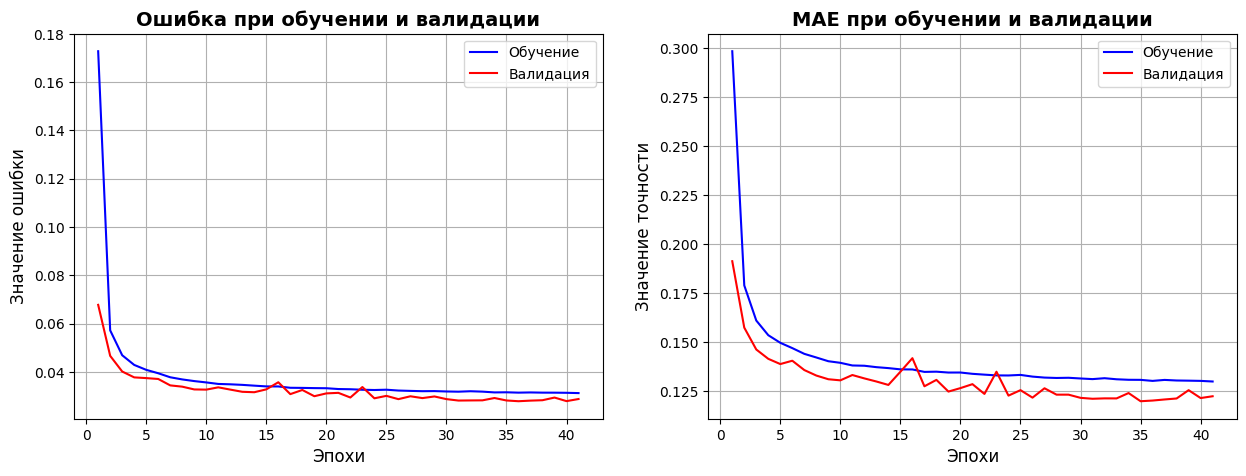

In [107]:
plot_training_curves(history)

82/82 [==============================] - 1s 5ms/step
mse:	2.3348
mae:	1.1487
r2:	0.9713


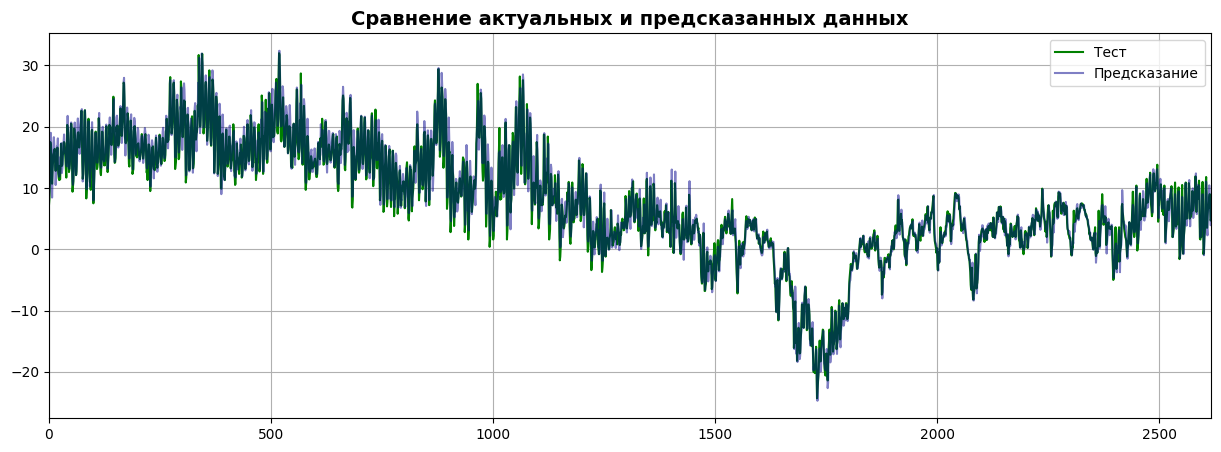

In [108]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 2.3

In [110]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='rmsprop', metrics='mae')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 19, 32)            160       
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8513 (33.25 KB)
Trainable params: 8513 (33.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [111]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
663/663 [==============================] - 35s 50ms/step - loss: 0.0995 - mae: 0.2256 - val_loss: 0.0485 - val_mae: 0.1613
Epoch 2/50
663/663 [==============================] - 31s 46ms/step - loss: 0.0467 - mae: 0.1608 - val_loss: 0.0383 - val_mae: 0.1420
Epoch 3/50
663/663 [==============================] - 27s 40ms/step - loss: 0.0408 - mae: 0.1500 - val_loss: 0.0680 - val_mae: 0.2029
Epoch 4/50
663/663 [==============================] - 34s 50ms/step - loss: 0.0378 - mae: 0.1445 - val_loss: 0.0428 - val_mae: 0.1611
Epoch 5/50
663/663 [==============================] - 35s 52ms/step - loss: 0.0352 - mae: 0.1393 - val_loss: 0.0324 - val_mae: 0.1345
Epoch 6/50
663/663 [==============================] - 31s 46ms/step - loss: 0.0340 - mae: 0.1365 - val_loss: 0.0324 - val_mae: 0.1302
Epoch 7/50
663/663 [==============================] - 34s 52ms/step - loss: 0.0333 - mae: 0.1349 - val_loss: 0.0372 - val_mae: 0.1457
Epoch 8/50
663/663 [==============================] - 29s 44ms

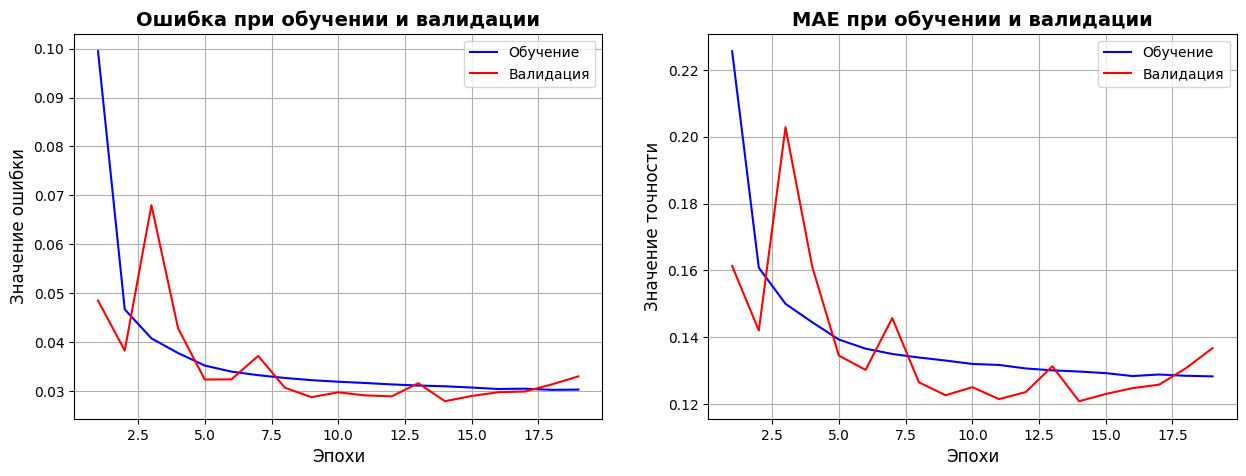

In [112]:
plot_training_curves(history)

82/82 [==============================] - 1s 7ms/step
mse:	2.4972
mae:	1.1957
r2:	0.9693


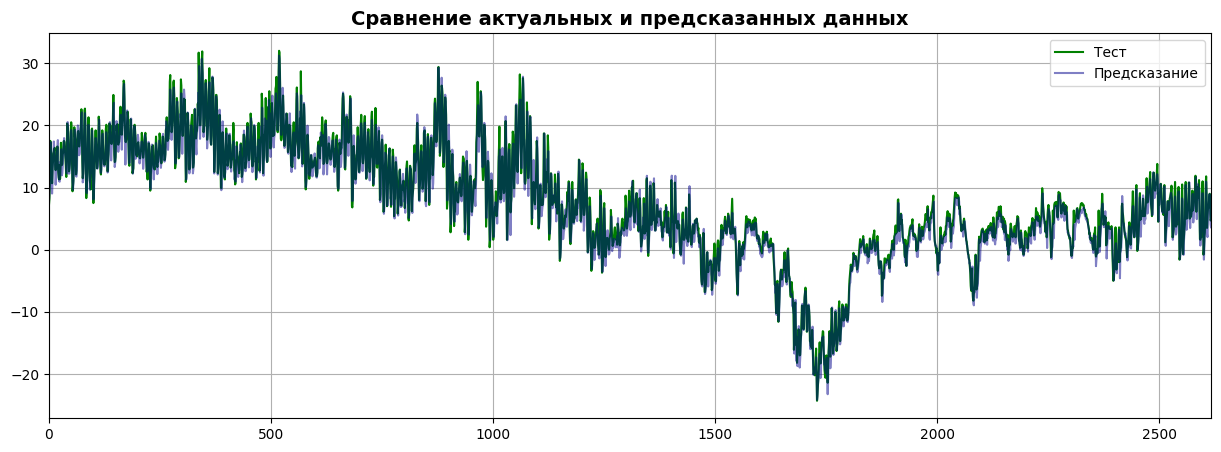

In [113]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 2.4

In [114]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='rmsprop', metrics='mae')
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 19, 32)            160       
                                                                 
 dropout (Dropout)           (None, 19, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8513 (33.25 KB)
Trainable params: 8513 (33.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
663/663 [==============================] - 31s 40ms/step - loss: 0.1600 - mae: 0.3016 - val_loss: 0.0648 - val_mae: 0.1875
Epoch 2/50
663/663 [==============================] - 29s 44ms/step - loss: 0.0996 - mae: 0.2401 - val_loss: 0.0548 - val_mae: 0.1737
Epoch 3/50
663/663 [==============================] - 29s 44ms/step - loss: 0.0876 - mae: 0.2240 - val_loss: 0.0669 - val_mae: 0.1983
Epoch 4/50
663/663 [==============================] - 30s 45ms/step - loss: 0.0821 - mae: 0.2171 - val_loss: 0.0495 - val_mae: 0.1687
Epoch 5/50
663/663 [==============================] - 31s 46ms/step - loss: 0.0801 - mae: 0.2138 - val_loss: 0.0454 - val_mae: 0.1543
Epoch 6/50
663/663 [==============================] - 28s 42ms/step - loss: 0.0764 - mae: 0.2098 - val_loss: 0.0739 - val_mae: 0.2193
Epoch 7/50
663/663 [==============================] - 30s 45ms/step - loss: 0.0755 - mae: 0.2078 - val_loss: 0.0441 - val_mae: 0.1574
Epoch 8/50
663/663 [==============================] - 29s 44ms

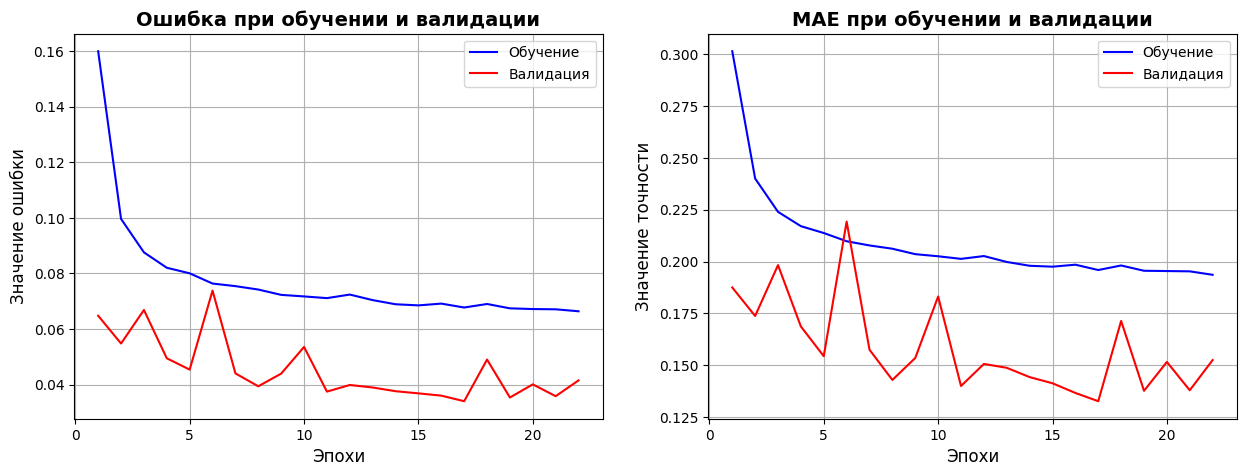

In [116]:
plot_training_curves(history)

82/82 [==============================] - 1s 5ms/step
mse:	3.0720
mae:	1.3103
r2:	0.9623


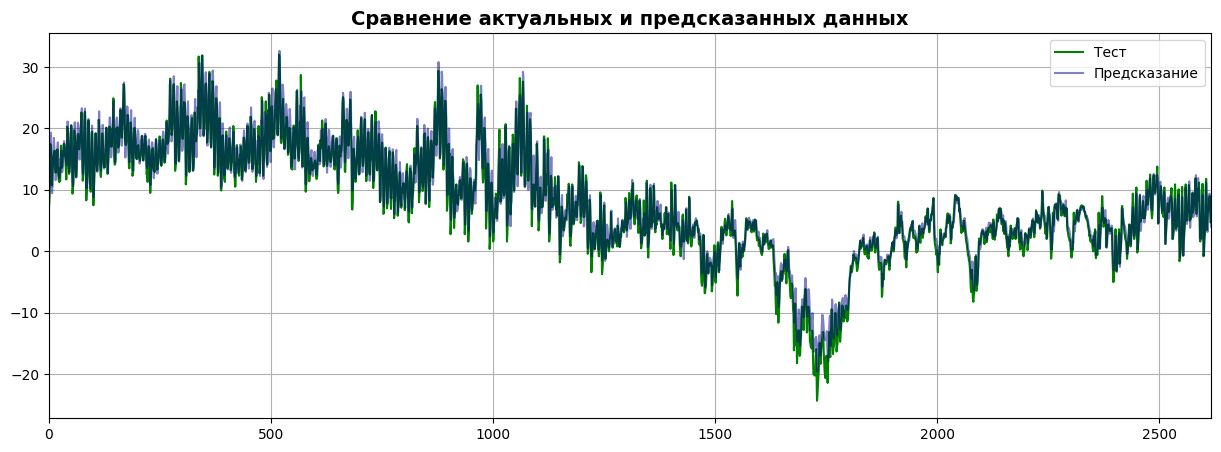

In [117]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

# Модель 3

## Модель 3.1

In [118]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 19, 32)            160       
                                                                 
 lstm_5 (LSTM)               (None, 19, 64)            24832     
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 37441 (146.25 KB)
Trainable params: 37441 (146.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [119]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
663/663 [==============================] - 58s 82ms/step - loss: 0.1142 - mae: 0.2444 - val_loss: 0.0417 - val_mae: 0.1480
Epoch 2/50
663/663 [==============================] - 54s 82ms/step - loss: 0.0435 - mae: 0.1560 - val_loss: 0.0367 - val_mae: 0.1396
Epoch 3/50
663/663 [==============================] - 52s 79ms/step - loss: 0.0402 - mae: 0.1497 - val_loss: 0.0414 - val_mae: 0.1570
Epoch 4/50
663/663 [==============================] - 54s 81ms/step - loss: 0.0364 - mae: 0.1424 - val_loss: 0.0316 - val_mae: 0.1296
Epoch 5/50
663/663 [==============================] - 53s 80ms/step - loss: 0.0342 - mae: 0.1375 - val_loss: 0.0310 - val_mae: 0.1273
Epoch 6/50
663/663 [==============================] - 52s 79ms/step - loss: 0.0333 - mae: 0.1360 - val_loss: 0.0362 - val_mae: 0.1426
Epoch 7/50
663/663 [==============================] - 54s 81ms/step - loss: 0.0326 - mae: 0.1339 - val_loss: 0.0296 - val_mae: 0.1237
Epoch 8/50
663/663 [==============================] - 56s 85ms

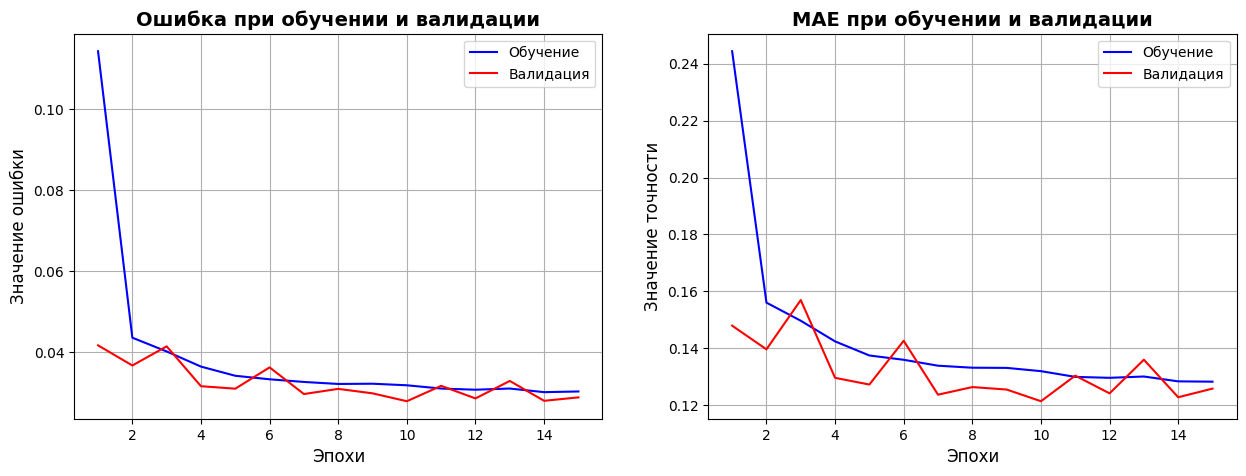

In [120]:
plot_training_curves(history)

82/82 [==============================] - 2s 11ms/step
mse:	2.2916
mae:	1.1461
r2:	0.9719


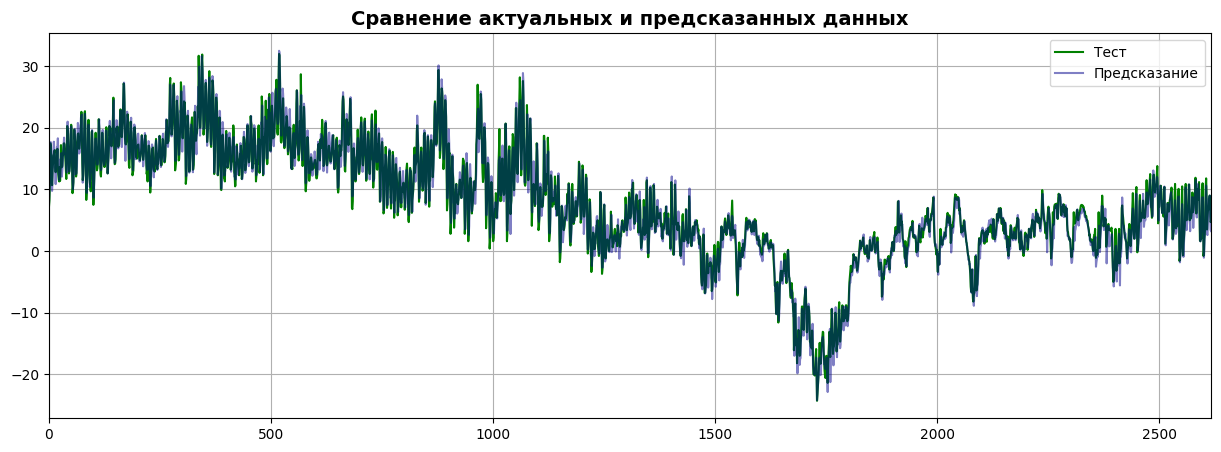

In [121]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 3.2

In [126]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(16, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 19, 16)            80        
                                                                 
 lstm_9 (LSTM)               (None, 19, 32)            6272      
                                                                 
 lstm_10 (LSTM)              (None, 16)                3136      
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 9505 (37.13 KB)
Trainable params: 9505 (37.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [123]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
663/663 [==============================] - 66s 92ms/step - loss: 0.1983 - mae: 0.3252 - val_loss: 0.0609 - val_mae: 0.1786
Epoch 2/50
663/663 [==============================] - 55s 83ms/step - loss: 0.0542 - mae: 0.1748 - val_loss: 0.0424 - val_mae: 0.1501
Epoch 3/50
663/663 [==============================] - 52s 79ms/step - loss: 0.0465 - mae: 0.1614 - val_loss: 0.0505 - val_mae: 0.1741
Epoch 4/50
663/663 [==============================] - 56s 85ms/step - loss: 0.0421 - mae: 0.1529 - val_loss: 0.0367 - val_mae: 0.1394
Epoch 5/50
663/663 [==============================] - 55s 83ms/step - loss: 0.0394 - mae: 0.1479 - val_loss: 0.0379 - val_mae: 0.1416
Epoch 6/50
663/663 [==============================] - 52s 79ms/step - loss: 0.0372 - mae: 0.1439 - val_loss: 0.0370 - val_mae: 0.1404
Epoch 7/50
663/663 [==============================] - 54s 81ms/step - loss: 0.0357 - mae: 0.1407 - val_loss: 0.0329 - val_mae: 0.1324
Epoch 8/50
663/663 [==============================] - 54s 81ms

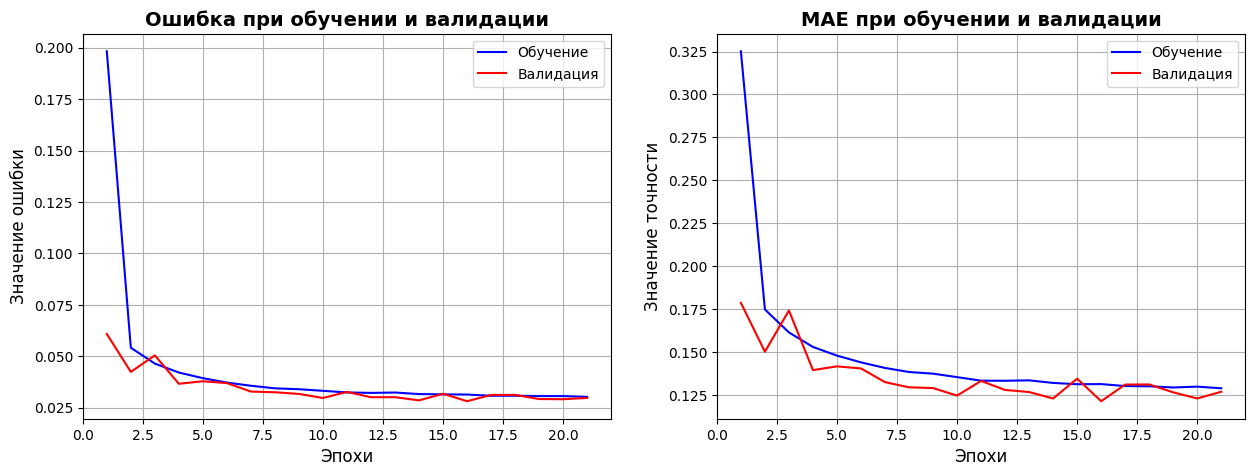

In [124]:
plot_training_curves(history)

82/82 [==============================] - 1s 8ms/step
mse:	2.3341
mae:	1.1358
r2:	0.9713


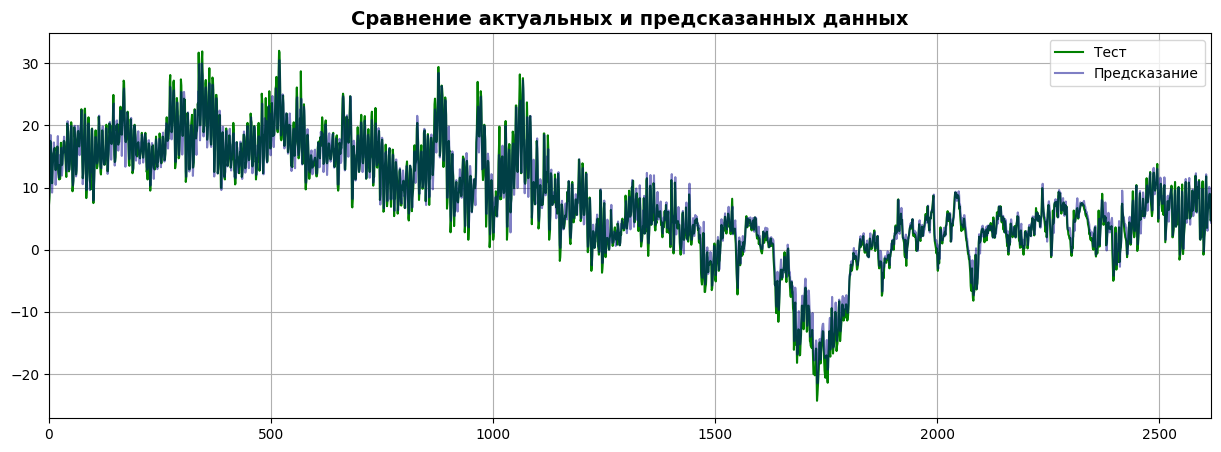

In [125]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 3.3

In [127]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='rmsprop', metrics='mae')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 19, 32)            160       
                                                                 
 lstm_11 (LSTM)              (None, 19, 64)            24832     
                                                                 
 lstm_12 (LSTM)              (None, 32)                12416     
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 37441 (146.25 KB)
Trainable params: 37441 (146.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [128]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
663/663 [==============================] - 67s 94ms/step - loss: 0.1229 - mae: 0.2582 - val_loss: 0.0566 - val_mae: 0.1834
Epoch 2/50
663/663 [==============================] - 61s 92ms/step - loss: 0.0478 - mae: 0.1647 - val_loss: 0.0400 - val_mae: 0.1485
Epoch 3/50
663/663 [==============================] - 59s 90ms/step - loss: 0.0392 - mae: 0.1480 - val_loss: 0.0604 - val_mae: 0.1915
Epoch 4/50
663/663 [==============================] - 65s 99ms/step - loss: 0.0364 - mae: 0.1422 - val_loss: 0.0455 - val_mae: 0.1684
Epoch 5/50
663/663 [==============================] - 62s 93ms/step - loss: 0.0347 - mae: 0.1385 - val_loss: 0.0427 - val_mae: 0.1585
Epoch 6/50
663/663 [==============================] - 58s 87ms/step - loss: 0.0337 - mae: 0.1364 - val_loss: 0.0357 - val_mae: 0.1388
Epoch 7/50
663/663 [==============================] - 62s 93ms/step - loss: 0.0332 - mae: 0.1352 - val_loss: 0.0479 - val_mae: 0.1723
Epoch 8/50
663/663 [==============================] - 62s 94ms

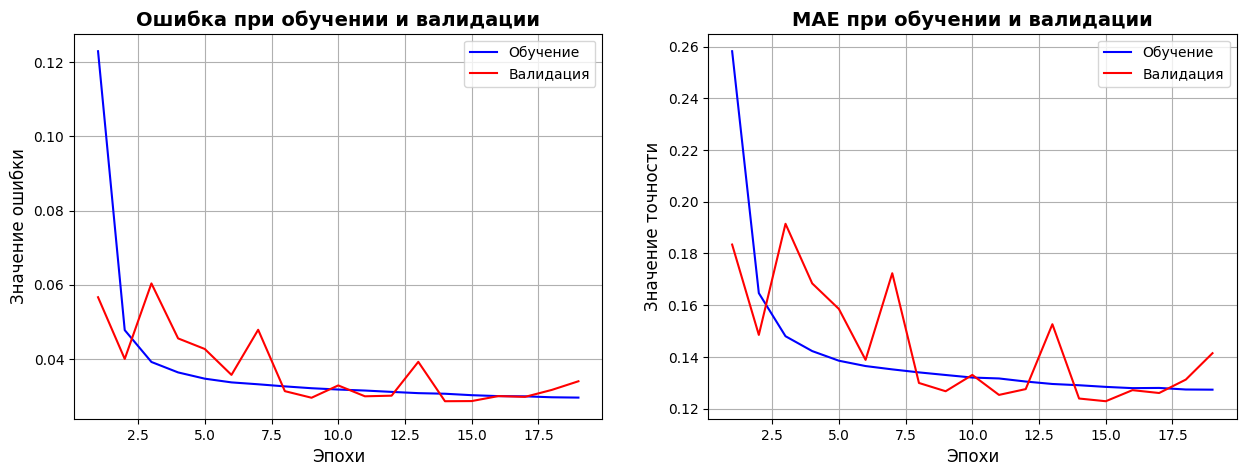

In [129]:
plot_training_curves(history)

82/82 [==============================] - 1s 8ms/step
mse:	2.5600
mae:	1.2253
r2:	0.9686


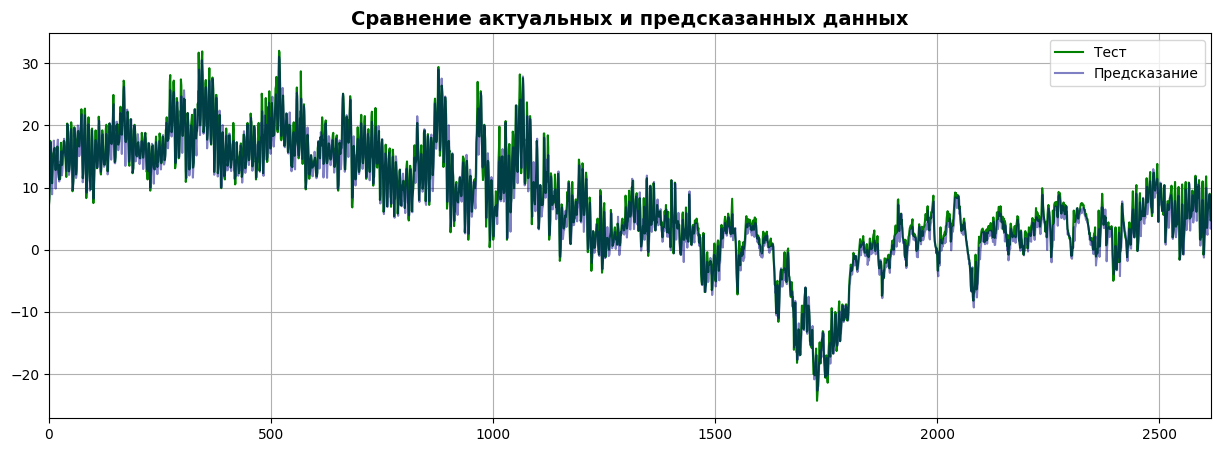

In [130]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 3.4

In [21]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.1),
    LSTM(32, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 19, 32)            160       
                                                                 
 dropout (Dropout)           (None, 19, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 19, 64)            24832     
                                                                 
 dropout_1 (Dropout)         (None, 19, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 37441 (146.25 KB)
Trainable params: 37441 

In [24]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
663/663 [==============================] - 70s 90ms/step - loss: 0.1404 - mae: 0.2786 - val_loss: 0.0584 - val_mae: 0.1770
Epoch 2/50
663/663 [==============================] - 53s 81ms/step - loss: 0.0666 - mae: 0.1960 - val_loss: 0.0473 - val_mae: 0.1587
Epoch 3/50
663/663 [==============================] - 53s 79ms/step - loss: 0.0564 - mae: 0.1800 - val_loss: 0.0390 - val_mae: 0.1455
Epoch 4/50
663/663 [==============================] - 56s 85ms/step - loss: 0.0503 - mae: 0.1703 - val_loss: 0.0369 - val_mae: 0.1419
Epoch 5/50
663/663 [==============================] - 52s 79ms/step - loss: 0.0471 - mae: 0.1651 - val_loss: 0.0458 - val_mae: 0.1609
Epoch 6/50
663/663 [==============================] - 53s 80ms/step - loss: 0.0450 - mae: 0.1617 - val_loss: 0.0440 - val_mae: 0.1574
Epoch 7/50
663/663 [==============================] - 56s 84ms/step - loss: 0.0431 - mae: 0.1571 - val_loss: 0.0342 - val_mae: 0.1367
Epoch 8/50
663/663 [==============================] - 53s 80ms

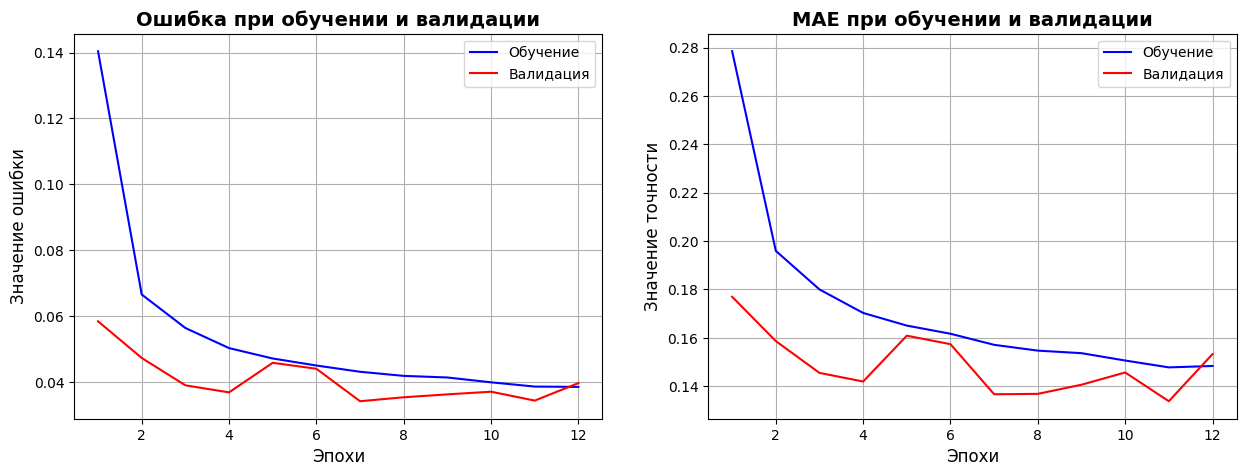

In [25]:
plot_training_curves(history)

82/82 [==============================] - 1s 11ms/step
mse:	2.7547
mae:	1.2693
r2:	0.9662


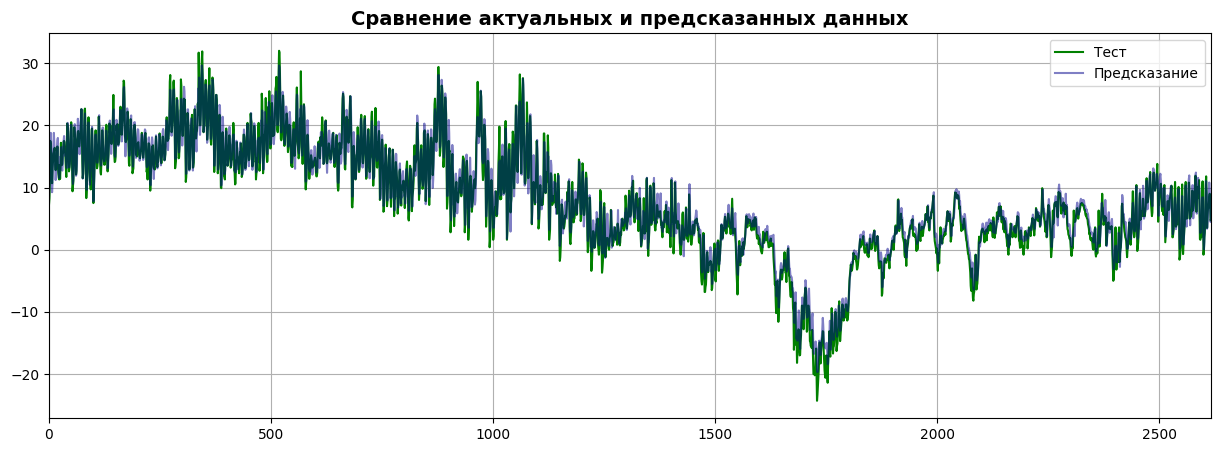

In [26]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)